In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
 
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
 
data = fetch_california_housing()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df.loc[:,'target'] = data['target']
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
def rmse(y_hat, y):
    return mean_squared_error(y_hat, y, squared = False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
X = df.drop('target', axis=1)
Y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
print(f'Размер обучающей выборки {X_train.shape}')
print(f'Размер тестовой выборки {X_test.shape}')

Размер обучающей выборки (15480, 8)
Размер тестовой выборки (5160, 8)


In [8]:
pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [9]:
y_pred = pipeline.predict(X_test)
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по метрике R2: 0.806
Качество по RSME: 0.5067


In [10]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('rf', RandomForestRegressor())],
 'verbose': False,
 'scaler': StandardScaler(),
 'rf': RandomForestRegressor(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

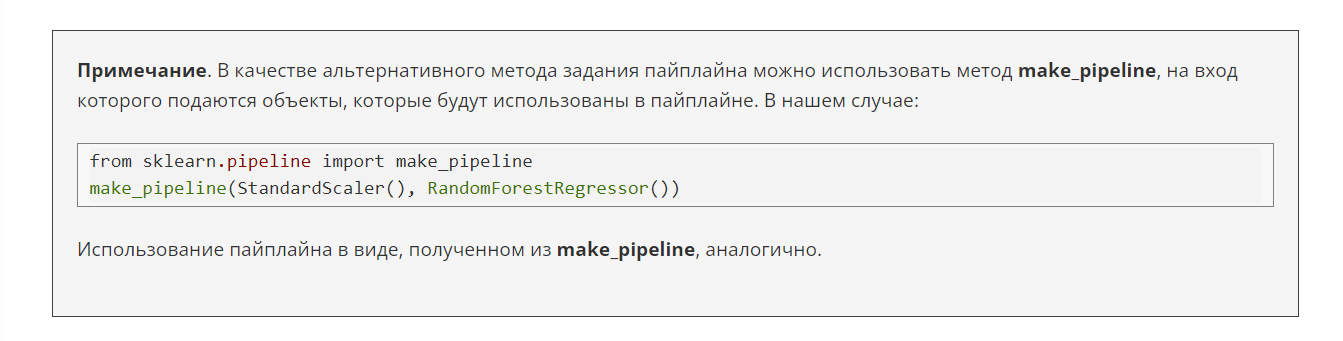

Попробуем теперь обратиться к отдельной части пайплайна. Попробуем вызвать значение n_estimator у случайного леса. Мы можем это сделать двумя способами: индексацией пайплайна или обращением через имя, которые мы задали ранее при создании ('rf').

In [11]:
print(pipeline[1].n_estimators)
print(pipeline['rf'].n_estimators)

100
100


Теперь попробуем задать этому же параметру значение 200. Можно это сделать, используя метод set_params(), на вход которого надо подавать конструкцию <название модуля>_ _<название параметра>. 

Обратите внимание на два нижних подчеркивания, которые используются в качестве литералов для разбиения названия модуля и названия его параметра. Без него компилятор будет неправильно интерпретировать параметр, который вы хотите изменить!

Данную структуру надо учитывать, когда для пайплайна задается GridSearch кросс-валидация. Попробуем взять 100, 200, 500 базовых моделей и сделать поиск оптимального параметра StardardScaler with_mean (типа bool, который отвечает за центровку данных, приводит распределение к нулевому среднему, по умолчанию — True. В противном случае среднее данных остается неизменным):

In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = {'scaler__with_mean':[True,False],
              'rf__n_estimators':[100, 200, 500]}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose = True)


grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(n_estimators=500))])


In [13]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по метрике R2: 0.8094
Качество по RSME: 0.5022


При использовании пайплайна для сборки обработки данных в один стек удобно воспользоваться Column Transformer.

Column Transformer — это специальный объект из модуля compose библиотеки sklearn, который позволяет применять набор трансформаций к данным. Этот объект позволяет преобразовывать разные столбцы или подмножества столбцов входных данных по отдельности, а результаты, сгенерированные каждым преобразователем, будут объединены в единую таблицу.

Однако, самим Column Transformer пользоваться не совсем удобно, для более удобной работы с ним мы будем использовать «обёртку» в виде функции make_column_transformer() из того же модуля библиотеки sklearn.

In [15]:
df_wine= pd.read_csv('data/Red.csv')
df_wine.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016


In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
ct = make_column_transformer(
     (StandardScaler(), ['Price']),
    (OneHotEncoder(), ['Country']))
print(ct)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(), ['Price']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Country'])])


In [17]:
from sklearn.compose import make_column_selector

ct_filtered = make_column_transformer(
       (StandardScaler(), make_column_selector(dtype_include=np.number)),
       (OneHotEncoder(), make_column_selector(dtype_include=object))
)

print(ct_filtered)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000012EEC962B90>),
                                ('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000012EED0449A0>)])


In [18]:
pipeline = Pipeline([('ct', ct), ('rf', RandomForestRegressor())])

In [19]:
X = df_wine[['Country', 'Price']]
y = df_wine['Rating']
pipeline.fit(X, y)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country'])])),
                ('rf', RandomForestRegressor())])

Теперь вызовем отдельно ct и преобразуем X. 

Важный момент: при отображении после преобразования ваш датасет будет представлен в виде sparse-матрицы (специальный формат для хранения больших, практически полностью нулевых матриц), поэтому надо будет вызвать метод toarray(). Так же мы можем получить названия колонок с onehotencoder с помощью метода .get_feature_names_out(), обратившись именно к энкодеру. 

In [20]:
pd.DataFrame(
    pipeline['ct'].transform(X).toarray(),
    columns=['Price'] + pipeline['ct'].transformers_[1][1].get_feature_names_out().tolist()
)

,Price,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Chile,Country_China,Country_Croatia,...,Country_Portugal,Country_Romania,Country_Slovakia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_United States,Country_Uruguay
0,0.657648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.278402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.373184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.358231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.117684,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8661,-0.266981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8662,-0.224358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8663,-0.178910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8664,-0.387784,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обученный пайплайн можно сохранить в формат pickle, например, используя библиотеку joblib. Далее его можно использовать после десериализации как решение «из коробки», применяя следующие методы.

**Примечание.** Формат pickle реализует двоичный протокол для сериализации/десериализации объектов для сохранения и последующего использования без каких-либо дополнительных преобразований. Удобен для переноса обученных моделей, предобработки и так далее.

In [25]:
import joblib
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [26]:
pipeline_loaded = joblib.load('pipeline.pkl')
print(pipeline_loaded)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country'])])),
                ('rf', RandomForestRegressor())])
